In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow import keras

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizzetion

In [ ]:
sentences = [
    "I love my doy",
    "I love my cat"
]

In [ ]:
tokenizer = Tokenizer(num_words=100)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)

In [ ]:
print(word_index)
print(sequences)

{'i': 1, 'love': 2, 'my': 3, 'doy': 4, 'cat': 5}
[[1, 2, 3, 4], [1, 2, 3, 5]]


# Sequencing

In [ ]:
sentences = [
    "I love my dog",
    "I love my cat",
    "You love my dog",
    "Do you think my dog is amazing?",
]

In [ ]:
tokenizer = Tokenizer(num_words = 100, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)


padded = pad_sequences(sequences) 
# add 0s to match the longest seq, or 
# , padding="post"
# , truncating="post"
# , maxlen = 5    

In [ ]:
print(word_index)
print(sequences)
print(padded)

{'<OOV>': 1, 'my': 2, 'love': 3, 'dog': 4, 'i': 5, 'you': 6, 'cat': 7, 'do': 8, 'think': 9, 'is': 10, 'amazing': 11}
[[5, 3, 2, 4], [5, 3, 2, 7], [6, 3, 2, 4], [8, 6, 9, 2, 4, 10, 11]]
[[ 5  3  2  4  0  0  0]
 [ 5  3  2  7  0  0  0]
 [ 6  3  2  4  0  0  0]
 [ 8  6  9  2  4 10 11]]


In [ ]:
test_data = [
    "i really love my dog",
    "my dog loves my manatee"
]

In [ ]:
test_seq = tokenizer.texts_to_sequences(test_data)
print(test_seq)

[[5, 1, 3, 2, 4], [2, 4, 1, 2, 1]]


# WEEK2 - Sercasm Model Training/Testing
a model to recognize sentiment in text

In [ ]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2022-09-10 17:54:41--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 2607:f8b0:4023:c0d::80
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2022-09-10 17:54:41 (188 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [ ]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [ ]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6574 - accuracy: 0.6035 - val_loss: 0.5401 - val_accuracy: 0.7968 - 3s/epoch - 6ms/step
Epoch 2/30
625/625 - 2s - loss: 0.4017 - accuracy: 0.8412 - val_loss: 0.3773 - val_accuracy: 0.8384 - 2s/epoch - 4ms/step
Epoch 3/30
625/625 - 2s - loss: 0.2988 - accuracy: 0.8812 - val_loss: 0.3501 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 4/30
625/625 - 2s - loss: 0.2487 - accuracy: 0.9019 - val_loss: 0.3401 - val_accuracy: 0.8581 - 2s/epoch - 4ms/step
Epoch 5/30
625/625 - 2s - loss: 0.2119 - accuracy: 0.9188 - val_loss: 0.3441 - val_accuracy: 0.8530 - 2s/epoch - 3ms/step
Epoch 6/30
625/625 - 2s - loss: 0.1861 - accuracy: 0.9289 - val_loss: 0.3576 - val_accuracy: 0.8530 - 2s/epoch - 3ms/step
Epoch 7/30
625/625 - 2s - loss: 0.1647 - accuracy: 0.9383 - val_loss: 0.3693 - val_accuracy: 0.8554 - 2s/epoch - 3ms/step
Epoch 8/30
625/625 - 2s - loss: 0.1459 - accuracy: 0.9459 - val_loss: 0.4023 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 9/30
625/625 - 2s 

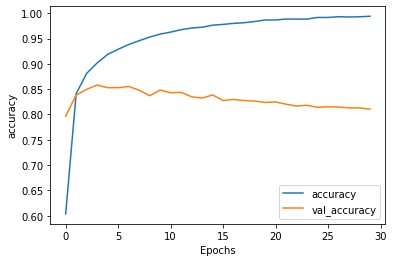

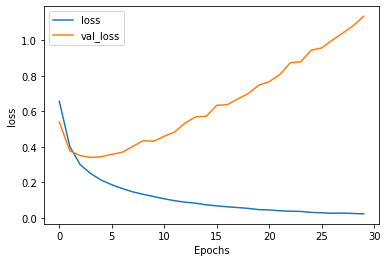

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[8.2313919e-01]
 [7.3964293e-06]]
